# **Загрузка датасета**

In [8]:
!pip install -q kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"askernagoev","key":"982e5884a31425664508f3830972bdaf"}'}

In [10]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [11]:
# Устанавливаем разрешения для файла
os.chmod('/root/.kaggle/kaggle.json', 0o600)

In [12]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 99% 778M/788M [00:09<00:00, 163MB/s]
100% 788M/788M [00:09<00:00, 87.9MB/s]


In [13]:
import zipfile
with zipfile.ZipFile('microsoft-catsvsdogs-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cats_vs_dogs')

In [14]:
os.listdir('/content/cats_vs_dogs')

['readme[1].txt', 'PetImages', 'MSR-LA - 3467.docx']

# **Подготовка данных**

In [24]:
import os
import shutil
from PIL import Image

In [25]:
# Функция для подготовки подмножества данных
def prepare_subset(src_dir, dest_dir, category, limit=5000):
    src_category_dir = os.path.join(src_dir, category)
    dest_category_dir = os.path.join(dest_dir, category)

    os.makedirs(dest_category_dir, exist_ok=True)

    copied_count = 0
    for filename in os.listdir(src_category_dir):
        if filename.lower().endswith('.jpg'):
            src_file = os.path.join(src_category_dir, filename)
            dest_file = os.path.join(dest_category_dir, filename)

            try:
                # Проверка корректности изображения
                with Image.open(src_file) as img:
                    img.verify()
                # Копирование изображения
                shutil.copy(src_file, dest_file)
                copied_count += 1
            except (IOError, SyntaxError):
                print(f"Пропущен поврежденный файл: {src_file}")

            if copied_count >= limit:
                break

In [26]:
# Указываем путь к исходной папке и создаем целевую папку
src_dir = '/content/cats_vs_dogs/PetImages'
dest_dir = '/content/cats_vs_dogs/Subset'
os.makedirs(dest_dir, exist_ok=True)

# Копируем 5000 файлов из каждой категории
prepare_subset(src_dir, dest_dir, 'Cat', limit=5000)
prepare_subset(src_dir, dest_dir, 'Dog', limit=5000)

Пропущен поврежденный файл: /content/cats_vs_dogs/PetImages/Cat/666.jpg
Пропущен поврежденный файл: /content/cats_vs_dogs/PetImages/Dog/11702.jpg


# **Подключение библиотек для создания сверточных нейросетей**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [27]:
# Преобразования изображений
datagen = ImageDataGenerator(
    rescale=1.0/255,        # Нормализация
    validation_split=0.2    # 20% данных на валидацию
)

# Генератор для тренировочных данных
train_generator = datagen.flow_from_directory(
    '/content/cats_vs_dogs/Subset',
    target_size=(128, 128),  # Размер изображений
    batch_size=32,           # Размер батча
    class_mode='binary',     # Бинарная классификация
    subset='training'
)

# Генератор для валидационных данных
val_generator = datagen.flow_from_directory(
    '/content/cats_vs_dogs/Subset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [28]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Выход для бинарной классификации
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 861ms/step - accuracy: 0.6050 - loss: 0.8265 - val_accuracy: 0.7220 - val_loss: 0.5486
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 262s 861ms/step - accuracy: 0.7449 - loss: 0.5166 - val_accuracy: 0.7235 - val_loss: 0.5278
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 223s 892ms/step - accuracy: 0.8009 - loss: 0.4309 - val_accuracy: 0.7360 - val_loss: 0.5162
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 215s 857ms/step - accuracy: 0.8643 - loss: 0.3219 - val_accuracy: 0.7450 - val_loss: 0.5704
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 862ms/step - accuracy: 0.9074 - loss: 0.2303 - val_accuracy: 0.7350 - val_loss: 0.6166


In [30]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.7373 - loss: 0.6087
Validation Accuracy: 0.74


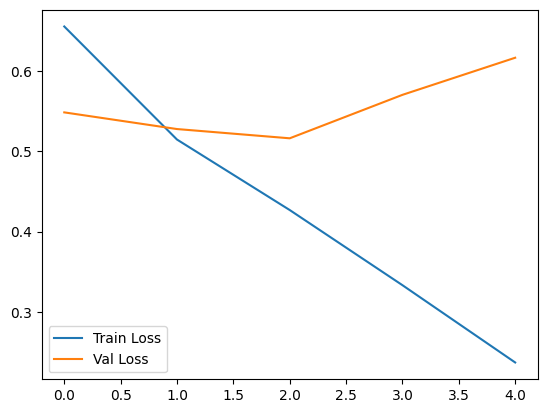

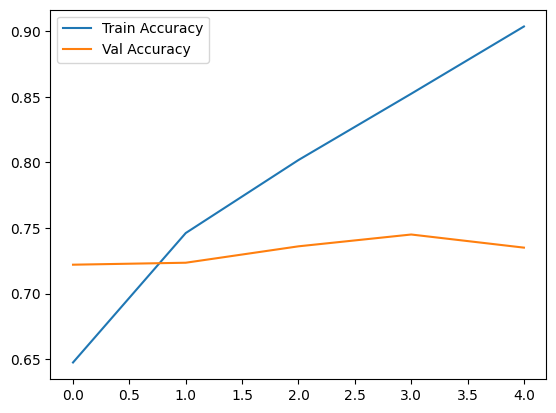

In [31]:
import matplotlib.pyplot as plt

# График ошибки
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# График точности
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()